<a href="https://colab.research.google.com/github/taechanha/inverseDesignMetaMatl/blob/main/%5Br%5D_vae_adjmat_brainnet_study_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
 
import numpy as np
import matplotlib.pyplot as plt
 
f = open("/content/dset4109.txt", 'r')
data = []
length = 0
for i in f:
  new = []
  new.append(i)
  data.append(new)
 
  # length of dataset
  length += 1
 
f.close()
 
# create dataset from data
dataset = []
for i in range(length):
  new = []
  for j in data[i][0].split(','):
    new.append(float(j))
  dataset.append(new)
 
 
# trim out label from dataset
# Ex Ey Ez
label = []
new = []
for line in dataset:
  tmp = []
  tmp.append(line.pop(-1))
  tmp.append(line.pop(-1))
  tmp.append(line.pop(-1))
  tmp.reverse()
  label.append(tmp)
 
print("label.shape: ", np.array(label).shape)
 
 
# create edge_index
edge_mat = np.zeros(shape=(27,27))
edge_index = []
 
for e in range(len(dataset)):
  for i in range(0, 27):
    for j in range(i+1, 27):
      edge_mat[i][j] = dataset[e].pop(0)
  edge_index.append(edge_mat + edge_mat.T)
 
 
# whole dataset to Tensor & train/test split
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
 
edge_index = torch.FloatTensor(edge_index)
label = torch.FloatTensor(label)
 
split = int(length * 0.8)
 
x_train = edge_index[:split]
y_train = label[:split]
x_val = edge_index[split:]
y_val = label[split:]
 
print("x_train, y_train, x_val shape: ", x_train.shape, y_train.shape, x_val.shape)
 
# create torch dataset
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
 
class CustomDataset(Dataset):
    def __init__(self, label, dataset, transform=None, target_transform=None):
        self.labels = label
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform
 
    def __len__(self):
        return len(self.labels)
 
    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.labels[idx]
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label
 
# create DataLoader
from torch.utils.data import DataLoader
 
training_data   = CustomDataset(label=y_train, dataset=x_train)
test_data       = CustomDataset(label=y_val, dataset=x_val)
train_loader    = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader     = DataLoader(test_data, batch_size=32, shuffle=False)

label.shape:  (4109, 3)
x_train, y_train, x_val shape:  torch.Size([3287, 27, 27]) torch.Size([3287, 3]) torch.Size([822, 27, 27])


In [2]:
def train(model, train_losses, epoch):
    model.train()
    train_loss = 0
    for x, y in train_loader:
        x, y = x.cuda().float(), y.cuda()
        optimizer.zero_grad()
        o, mu, logvar = model(x)
        loss = loss_function(o, x, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print('====> Epoch: {} loss: {:.4f}'.format(e, train_loss / len(x_train)))
    train_losses.append(train_loss / len(x_train))

def test(model, val_losses):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda().float(), y.cuda()       
            o, mu, logvar = model(x)
            loss = loss_function(o, x, mu, logvar)
            
            test_loss += loss.item()
    print('====> Test set loss: {:.4f}'.format(test_loss / len(x_val)))
    val_losses.append(test_loss / len(x_val))


def test_pred(model):
    y_pred = []
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda().float(), y.cuda()       
            o, mu, logvar = model(x)
            y_pred.append(o)

            loss = loss_function(o, x, mu, logvar)
            test_loss += loss.item()
    print('====> Test set loss: {:.4f}'.format(test_loss / len(x_val)))

    return y_pred

In [ ]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 2, 2)
        
        self.fc1 = nn.Linear(2704, 2)
        self.fc2 = nn.Linear(2704, 2)
        self.fc3 = nn.Linear(2, 2704)

        self.deconv1 = nn.ConvTranspose2d(16, 1, 3, 2)
        #self.deconv2 = nn.ConvTranspose2d(1, 1, 3, 2)

    def encode(self, x):
        #print("first:                      ", x.shape)
        x = x.unsqueeze(1)
        #print("unsqueeze(1):               ", x.shape)
        x = self.conv1(x)
        #print("conv1(x):                   ", x.shape)

        x = x.view(x.size(0), -1)
        #print("view(x.size(0), -1):        ", x.shape)
        mu, sigma = self.fc1(x), self.fc2(x)
        #print("mu:                         ", mu.shape)
    
        return mu, sigma

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        #print()
        #print("first:                     ", z.shape)
        x = self.fc3(z)
        #print("fc3(z):                    ", x.shape)

        x = x.view(x.size(0), 16, 13, 13)
        #print("view(x.size(0), 16, 13, 13): ", x.shape)

        x = self.deconv1(x)
        #print("deconv1(x):                ", x.shape)
        #x = self.deconv2(x)
        #print("deconv2(x):                ", x.shape)
        x = x.view(-1, 729)
        #print("view(-1, 729):             ", x.shape)
        x = torch.sigmoid(x)

        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE().cuda()
model

VAE(
  (conv1): Conv2d(1, 16, kernel_size=(2, 2), stride=(2, 2))
  (fc1): Linear(in_features=2704, out_features=2, bias=True)
  (fc2): Linear(in_features=2704, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=2704, bias=True)
  (deconv1): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2))
)

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 729), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)
#loss_function = loss_function()
epochs = 50

# for loss plot
tloss = []
vloss = []

for e in range(1, epochs+1):
    train(model, tloss, e)
    test(model, vloss)

y_pred = test_pred(model)

====> Epoch: 1 loss: 142.8007
====> Test set loss: 143.6416
====> Epoch: 2 loss: 142.7592
====> Test set loss: 143.5353
====> Epoch: 3 loss: 142.7422
====> Test set loss: 143.4810
====> Epoch: 4 loss: 142.7209
====> Test set loss: 143.5037
====> Epoch: 5 loss: 142.6319
====> Test set loss: 143.5852
====> Epoch: 6 loss: 142.6671
====> Test set loss: 143.5448
====> Epoch: 7 loss: 142.6454
====> Test set loss: 143.5057
====> Epoch: 8 loss: 142.6182
====> Test set loss: 143.3561
====> Epoch: 9 loss: 142.5958
====> Test set loss: 143.4077
====> Epoch: 10 loss: 142.5032
====> Test set loss: 143.2978
====> Epoch: 11 loss: 142.4892
====> Test set loss: 143.2747
====> Epoch: 12 loss: 142.4512
====> Test set loss: 143.2987
====> Epoch: 13 loss: 142.4332
====> Test set loss: 143.1920
====> Epoch: 14 loss: 142.4385
====> Test set loss: 143.3112
====> Epoch: 15 loss: 142.4256
====> Test set loss: 143.1762
====> Epoch: 16 loss: 142.4015
====> Test set loss: 143.1630
====> Epoch: 17 loss: 142.3888
==

In [ ]:
y_pred = test_pred(model)

====> Test set loss: 143.6845


In [ ]:
y_pred[0].shape, x_val[:32].shape

(torch.Size([32, 729]), torch.Size([32, 27, 27]))

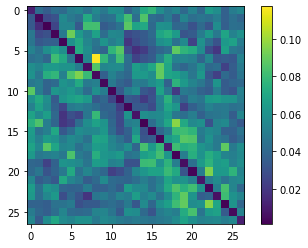

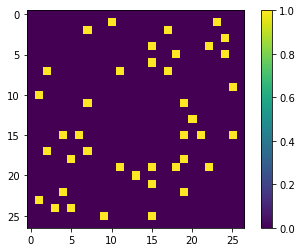

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_pred = y_pred[0].view(32, 27, 27)

plt.imshow(x_pred[2].cpu())
plt.colorbar()
plt.show()

plt.imshow(x_val[2])
plt.colorbar()
plt.show()

In [ ]:
#

In [14]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

out_dim = 16

class VAE(nn.Module):
    def __init__(self, out_dim=out_dim, fc_in_dim=out_dim*(int((27-3+2*0)/1)+1)**2):
        super(VAE, self).__init__()
        self.conv1 = nn.Conv2d(1, out_dim, 3, 1)
        #self.conv2 = nn.Conv2d(out_dim, out_dim*2, 3, 1)

        self.fc0 = nn.Linear(fc_in_dim, fc_in_dim//256)
        self.fc1 = nn.Linear(fc_in_dim//256, 2)
        self.fc2 = nn.Linear(fc_in_dim//256, 2)
        
        self.fc3 = nn.Linear(2, fc_in_dim//256)
        self.fc30 = nn.Linear(fc_in_dim//256, fc_in_dim)

        #self.deconv1 = nn.ConvTranspose2d(out_dim*2, out_dim, 3, 1)
        self.deconv1 = nn.ConvTranspose2d(out_dim, 1, 3, 1)

    def encode(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc0(x))

        mu, sigma = F.relu(self.fc1(x)), F.relu(self.fc2(x))
        return mu, sigma

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc30(x))

        x = x.view(x.size(0), out_dim, 25, 25)

        x = self.deconv1(x)

        x = x.view(-1, 729)
        x = torch.sigmoid(x)

        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



def weights_init(m):
    if isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_normal_(m.weight.data, nn.init.calculate_gain('relu'))
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, nn.init.calculate_gain('relu'))
 
torch.manual_seed(42)
model = VAE().cuda()
model.apply(weights_init)
print("model: \n", model)

model: 
 VAE(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc0): Linear(in_features=10000, out_features=39, bias=True)
  (fc1): Linear(in_features=39, out_features=2, bias=True)
  (fc2): Linear(in_features=39, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=39, bias=True)
  (fc30): Linear(in_features=39, out_features=10000, bias=True)
  (deconv1): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
)


In [15]:
# the number of trainable parameter
sum(p.numel() for p in model.parameters() if p.requires_grad)

790621

In [16]:
def loss_function(recon_x, x, mu, logvar):
    
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 729), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)
#loss_function = loss_function()
epochs = 100

# for loss plot
tloss = []
vloss = []

for e in range(1, epochs+1):
    train(model, tloss, e)
    test(model, vloss)

y_pred = test_pred(model)

====> Epoch: 1 loss: 293.2416
====> Test set loss: 234.8544
====> Epoch: 2 loss: 216.6901
====> Test set loss: 199.7947
====> Epoch: 3 loss: 189.4448
====> Test set loss: 182.4901
====> Epoch: 4 loss: 172.8513
====> Test set loss: 167.1502
====> Epoch: 5 loss: 160.8888
====> Test set loss: 157.6466
====> Epoch: 6 loss: 153.5862
====> Test set loss: 151.1491
====> Epoch: 7 loss: 149.0759
====> Test set loss: 147.9188
====> Epoch: 8 loss: 146.3989
====> Test set loss: 145.7970
====> Epoch: 9 loss: 144.7205
====> Test set loss: 144.5386
====> Epoch: 10 loss: 143.6363
====> Test set loss: 143.7195
====> Epoch: 11 loss: 142.9016
====> Test set loss: 142.9517
====> Epoch: 12 loss: 142.2504
====> Test set loss: 142.5071
====> Epoch: 13 loss: 141.8083
====> Test set loss: 142.3235
====> Epoch: 14 loss: 141.4333
====> Test set loss: 141.7956
====> Epoch: 15 loss: 141.1808
====> Test set loss: 141.9122
====> Epoch: 16 loss: 140.8725
====> Test set loss: 141.4351
====> Epoch: 17 loss: 140.7173
==

In [17]:
y_pred = test_pred(model)

====> Test set loss: 139.7989


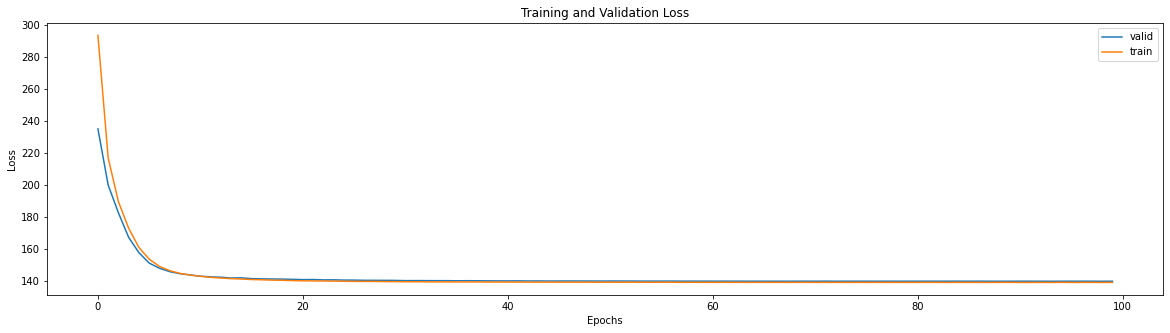

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.title("Training and Validation Loss")
plt.plot(np.array(vloss), label="valid")
plt.plot(np.array(tloss), label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

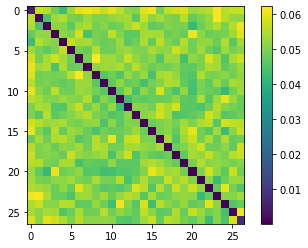

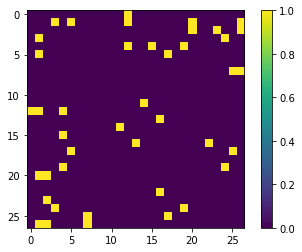

In [23]:
import numpy as np
import matplotlib.pyplot as plt

x_pred = y_pred[0].view(32, 27, 27)

plt.imshow(x_pred[1].cpu())
plt.colorbar()
plt.show()

plt.imshow(x_val[1])
plt.colorbar()
plt.show()

In [ ]:


#



In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
class UnFlatten(nn.Module):
    def forward(self, input, size=256):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=256, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=6, stride=3),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=7, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=1),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp.cuda()
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        #print(z.shape)
        z = self.fc3(z)
        #print(z.shape)
        z = self.decoder(z)
        #print(z.shape)
        z = z.view(-1, 729)
        return z

    def forward(self, x):
        x = x.unsqueeze(1)
        #print(x.shape)
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

model = VAE().cuda()
model

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (fc2): Linear(in_features=256, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=256, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(256, 128, kernel_size=(6, 6), stride=(3, 3))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(6, 6), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(32, 1, kernel_size=(6, 6), stride=(1, 1))
    (8): Sigmoid()
  )
)

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 729), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)
#loss_function = loss_function()
epochs = 20

# for loss plot
tloss = []
vloss = []

for e in range(1, epochs+1):
    train(model, tloss, e)
    test(model, vloss)

y_pred = test_pred(model)

====> Epoch: 1 loss: 282.8935
====> Test set loss: 181.3815
====> Epoch: 2 loss: 163.3090
====> Test set loss: 154.7524
====> Epoch: 3 loss: 151.2946
====> Test set loss: 149.5343
====> Epoch: 4 loss: 147.2088
====> Test set loss: 146.3136
====> Epoch: 5 loss: 144.8886
====> Test set loss: 144.8067
====> Epoch: 6 loss: 143.4580
====> Test set loss: 143.7816
====> Epoch: 7 loss: 142.4845
====> Test set loss: 142.7119
====> Epoch: 8 loss: 141.9473
====> Test set loss: 142.2225
====> Epoch: 9 loss: 141.4172
====> Test set loss: 141.9340
====> Epoch: 10 loss: 141.0864
====> Test set loss: 141.7241
====> Epoch: 11 loss: 140.7778
====> Test set loss: 141.3293
====> Epoch: 12 loss: 140.5780
====> Test set loss: 141.2286
====> Epoch: 13 loss: 140.3043
====> Test set loss: 140.9262
====> Epoch: 14 loss: 140.0917
====> Test set loss: 140.7642
====> Epoch: 15 loss: 139.8992
====> Test set loss: 140.5122
====> Epoch: 16 loss: 139.7500
====> Test set loss: 140.3475
====> Epoch: 17 loss: 139.6207
==

In [ ]:
y_pred[0].shape, x_val[:32].shape

(torch.Size([32, 729]), torch.Size([32, 27, 27]))

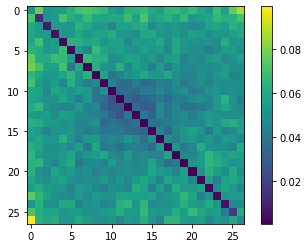

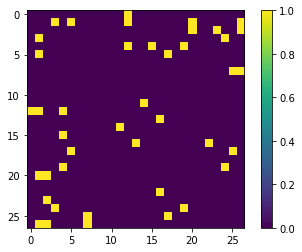

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_pred = y_pred[0].view(32, 27, 27)

plt.imshow(x_pred[1].cpu())
plt.colorbar()
plt.show()

plt.imshow(x_val[1])
plt.colorbar()
plt.show()

In [ ]:
#